# Tâches 7

In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pymatgen.electronic_structure import plotter
import matplotlib.pyplot as plt

In [2]:
mp_key = "bsvkvKtIeOMa1amMu5ZlNLCEpRMHPSeb"
mp_id = "mp-505297"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
conv_struc = SpacegroupAnalyzer(prim_struc).get_conventional_standard_structure()
symmops = SpacegroupAnalyzer(conv_struc).get_space_group_operations()

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{E\\ -\\ E_f\\ (eV)}$'>

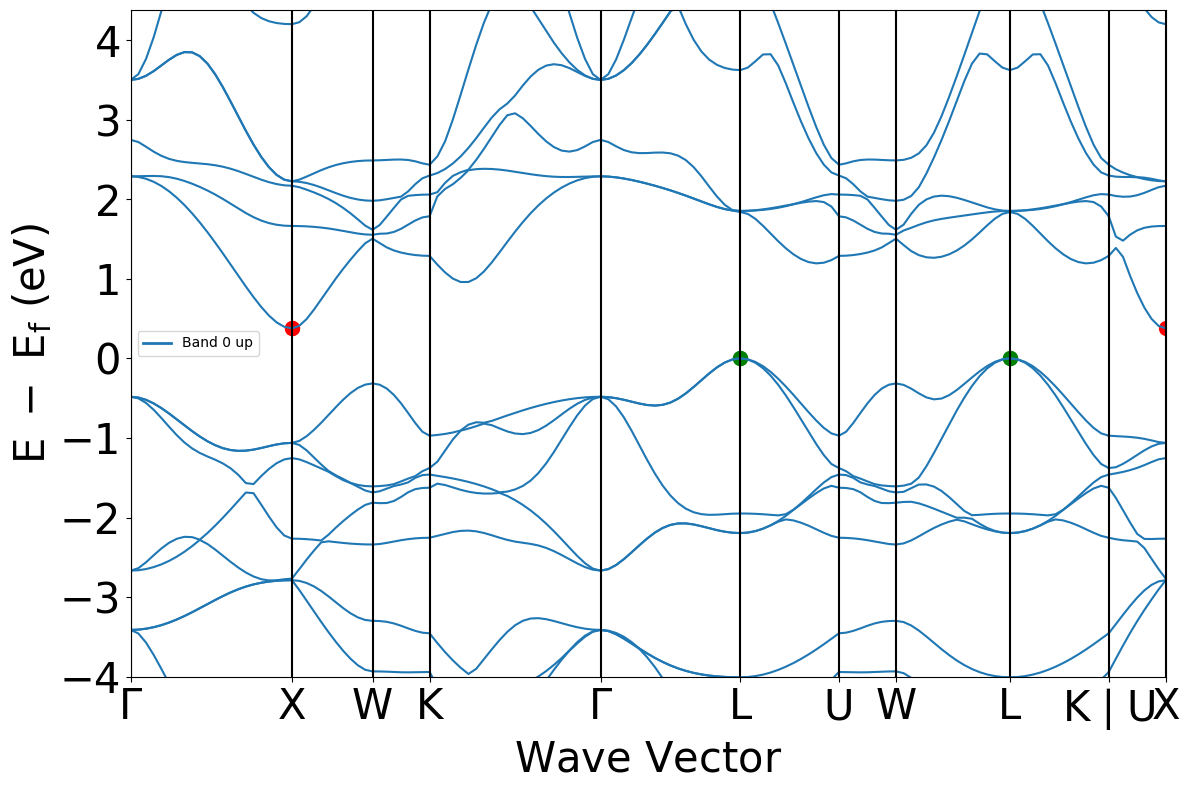

In [4]:
BSPlotter(el_bs).get_plot(vbm_cbm_marker=True)

## Bande interdite

In [5]:
gap = el_bs.get_band_gap()
e_band = gap.get('energy')
print('Energie de la bande :', e_band, 'eV.')
if gap.get('direct') == False:
    print('La bande interdite est indirect.')
else:
    print('La bande interdite est direct.')

print('La bande interdite se situe entre 0 eV et {} eV.'.format(e_band))
print("Vecteur de transition :", gap['transition'])

Energie de la bande : 0.37729999999999997 eV.
La bande interdite est indirect.
La bande interdite se situe entre 0 eV et 0.37729999999999997 eV.
Vecteur de transition : L-X


### Analyse

La zone interdite englobe un ensemble de niveaux énergétiques inaccessibles aux électrons du cristal. Malgré un petit écart inférieur à 1 eV, indiquant ainsi la conductivité du matériau, le site Materials Project rapporte un écart de 0.623 eV, dépassant largement notre mesure. Cependant, selon Materials Project, les écarts dans les bandes interdites calculées sont souvent sous-estimés d'environ 50%, ce qui concorde avec notre observation. La transition se fait du kpoint L au kpoint X.

## Dernière bande de valence

In [6]:
vbm =el_bs.get_vbm()
print('Energie du maximum de la bande de valence = {} eV'.format(vbm['energy']))
print(vbm['band_index'])

Energie du maximum de la bande de valence = 6.9534 eV
defaultdict(<class 'list'>, {<Spin.up: 1>: [13, 14]})


Analyse: les bandes 13 et 14 contiennent la plus grande énergie de la bande de valence (points verts sur le diagramme de bandes).

## Première bande de conduction

In [7]:
cbm = el_bs.get_cbm()
print('Energie du maximum de la bande de valence = {} eV'.format(cbm['energy']))
print(cbm['band_index'])

Energie du maximum de la bande de valence = 7.3307 eV
defaultdict(<class 'list'>, {<Spin.up: 1>: [15]})


Analyse: la 15ème bande contient la plus basse énergie de la bande de conduction (point rouge sur le diagramme de bandes).

## Dispersion de ces bandes

In [8]:
data = plotter.BSPlotter(el_bs).bs_plot_data()
x = data.get('ticks').get('distance')
x = np.array([x[0], x[1], x[3], x[5], x[7], x[9], x[11], x[13], x[15], x[17], x[18]])
y = data.get('energy')
dx = np.zeros(10)
dyc = np.zeros(10)
dyv = np.zeros(10)
mc = np.zeros(10)
mv = np.zeros(10)

for i in range(10):
    dx[i] = x[i+1] - x[i]
    
for i in range(10):
    dyv[i] =y.get('1')[i][14][-1] - y.get('1')[i][14][0]
    dyc[i] =y.get('1')[i][15][-1] - y.get('1')[i][15][0]
    
for i in range (10):
    mc[i] = dyc[i]/dx[i]
    mv[i] = dyv[i]/dx[i] 
    

print("En valeur absolue:")
mxV = np.max(abs(mv))
print("Dispersion maximale pour la bande de valence: ", mxV)
mxC = np.max(abs(mc))
print("Dispersion maximale pour la bande de conduction: ", mxC)
mnV = np.min(abs(mv))
print("Plus faible dispersion pour la bande de valence: ", mnV)
mnC = np.min(abs(mc))
print("Plus faible dispersion pour la bande de conduction: ", mnC)

En valeur absolue:
Dispersion maximale pour la bande de valence:  1.831511666920709
Dispersion maximale pour la bande de conduction:  2.5420600194074714
Plus faible dispersion pour la bande de valence:  0.2529496296082543
Plus faible dispersion pour la bande de conduction:  0.4680684923159416


### Représentation de la dispersion par des flèches

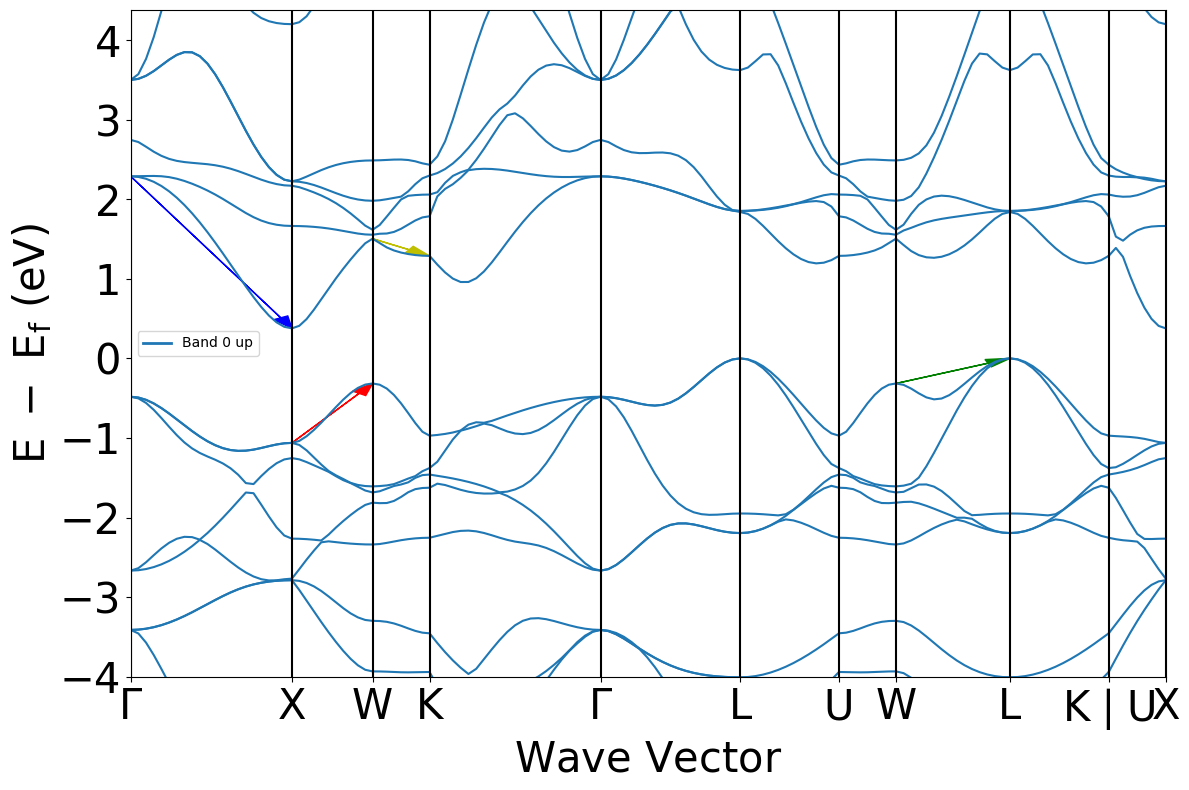

In [9]:
BSPlotter(el_bs).get_plot()
plt.arrow(x[7], (y.get('1')[7][14])[0], dx[7], dyv[7], color = 'g', head_width = 0.1,length_includes_head=True)
plt.arrow(x[1], (y.get('1')[1][14])[0], dx[1], dyv[1], color = 'r', head_width = 0.1,length_includes_head=True)
plt.arrow(x[0], (y.get('1')[0][15])[0], dx[0], dyc[0], color = 'b', head_width = 0.1,length_includes_head=True)
plt.arrow(x[2], (y.get('1')[2][15])[0], dx[2], dyc[2], color = 'y', head_width = 0.1,length_includes_head=True)

plt.show()

### Dispertion sur la dernière bande de valence

La dispersion maximale de la dernière bande de valence se produit à $\Gamma$ -X, avec une valeur de 1.83, indiquée en bleu.
La dispersion minimale de cette bande se trouve à W-K, marquée par une flèche jaune et affichant une valeur de 0.25.

### Dispertion sur la première bande de conduction

La dispersion la plus importante pour la première bande de conduction se produit à X-W, avec une valeur de 2.54, indiquée en rouge. La dispersion minimale pour la dernière bande de valence se situe à W-L, représentée par une flèche verte avec une valeur de 0.47.

## Masse effective 

Pour calculer la masse effective on va supposer une dispersion parabolique. On peut alors avoir la formule suivante pour déterminer la masse effective:
$$ m^* = \frac{\hbar^2 \cdot k^2}{2 \cdot E(k)} = \frac{\hbar^2 \cdot (k_x^2 + k_y^2 + k_z^2)}{2 \cdot E(k)} $$
E(k) est l'énergie d'un électron de vecteur d'onde k (3 dimensions) dans la bande considérée.${\hbar} = \frac{h}{2\pi}$ avec 
h la constante de Planck et vaut 6.626 x $10^{-34}$ Js.

###  Masse effective au sommet de la dernière bande de valence

In [10]:
hbar = (6.62607015*10**(-34))/(2*np.pi) 
eV = 1.602176634*10**(-19) 
h_bar = 6.5821e-16 #hbar/eV 
kpoint_vbm = vbm['kpoint'].cart_coords
m_vbm = (h_bar**2 * (kpoint_vbm[0]**2+kpoint_vbm[1]**2+kpoint_vbm[2]**2))/(2*abs(vbm['energy']))
print('La masse effective au sommet de la dernière bande de valence = {} kg.'.format(m_vbm))

La masse effective au sommet de la dernière bande de valence = 2.3979564608440126e-32 kg.


### Masse effective à la base de la première bande de conduction

In [11]:
kpoint_cbm = cbm['kpoint'].cart_coords

m_cbm = (h_bar**2 * (kpoint_cbm[0]**2+kpoint_cbm[1]**2+kpoint_cbm[2]**2))/(2*cbm['energy'])
print('La masse effective à la base de la première bande de conduction = {} kg.'.format(m_cbm))

La masse effective à la base de la première bande de conduction = 3.03271637630472e-32 kg.
